<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/IInd_TransferLearning_in_NNN_plus2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:

nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Plot function

In [3]:
def avg_prob(unique_temperatures, predictions, temperatures):
  # Initialize an array to store average prediction probabilities for each unique temperature
  average_probabilities = np.zeros_like(unique_temperatures, dtype=float)

  # Calculate average prediction probability for each unique temperature
  for i, temp in enumerate(unique_temperatures):
      # Find indices corresponding to the current unique temperature
      temp_indices = np.where(temperatures == temp)
      # Extract prediction probabilities for these indices
      temp_predictions = predictions[temp_indices]
      # Calculate average prediction probability
      average_prob = np.mean(temp_predictions)
      # Store the average probability
      average_probabilities[i] = average_prob
  return average_probabilities

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predictions' is the array containing prediction probabilities
# and 'temperatures' is the array containing corresponding temperatures
def plot_proba(temperatures, predictions1, predictions2, label1 = 'Ordered state', label2 = 'Disordered state'):
# Calculate unique temperature values and their corresponding indices
  unique_temperatures, indices = np.unique(temperatures, return_inverse=True)
  avg_proba1 = avg_prob(unique_temperatures, predictions1, temperatures)
  avg_proba2 = avg_prob(unique_temperatures, predictions2, temperatures)

  # Plot the average prediction probabilities against temperature
  plt.figure(figsize=(8, 6))
  plt.plot(unique_temperatures, avg_proba1, marker='o', linestyle='-', label = label1)
  plt.plot(unique_temperatures, avg_proba2, marker='o', linestyle='-', label = label2)
  plt.legend()
  plt.xlabel('Temperature')
  plt.ylabel('Average Prediction Probability')
  plt.title('Average Prediction Probability per Temperature')

  plt.grid(True)
  plt.show()


### Concatenate npz files

In [5]:
def combine_npz_files(file1, file2, combined_file):
    # Load data and labels from the first .npz file
    data1 = np.load(file1)['X']
    labels1 = np.load(file1)['y']

    # Load data and labels from the second .npz file
    data2 = np.load(file2)['X']
    labels2 = np.load(file2)['y']

    # Concatenate data and labels along the appropriate axis
    combined_data = np.concatenate((data1, data2), axis=0)
    combined_labels = np.concatenate((labels1, labels2), axis=0)

    # Save the combined data and labels into a new .npz file
    np.savez(combined_file, X=combined_data, y=combined_labels)

### Model

#### Accuracy, train and test functions

In [6]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [7]:
import numpy as np

def calculate_accuracy_np(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).astype(float)

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape

    # Calculate the number of correct predictions
    correct = np.sum(predicted == labels).astype(float) / 2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.shape[0]

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [8]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  model.train()
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [9]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [10]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [11]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [12]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms

# Define a function to generate rotated data
def rotate_data(X):
    rotated_X = torch.rot90(X, k=1, dims=(0, 1))  # Rotate data by 90 degrees clockwise
    return rotated_X

# Modify the dataset to include both original and rotated data
def create_combined_dataset_with_augmentation(original_dataset):
    combined_dataset = []
    for X, Y in original_dataset:
        rotated_X = rotate_data(X)
        combined_dataset.append((X, Y))  # Add original data
        combined_dataset.append((rotated_X, Y))  # Add rotated data
    return combined_dataset

In [13]:
def create_combined_dataset(dataset1, dataset2):
    combined_dataset = []
    for X, Y in dataset1:
        combined_dataset.append((X, Y))  # Add original data
    for X, Y in dataset2:
        combined_dataset.append((X, Y))  # Add original data
    return combined_dataset

In [14]:
def file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [15]:
def full_file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    # Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [16]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


In [17]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader named original_dataloader
# Define a new DataLoader class to subset the original DataLoader
class SubsetDataLoader(DataLoader):
    def __init__(self, dataloader, num_batches):
        super(SubsetDataLoader, self).__init__(dataloader.dataset, batch_size=dataloader.batch_size)
        self.dataloader = dataloader
        self.num_batches = num_batches
        self.current_batch = 0

    def __iter__(self):
        self.current_batch = 0
        self.dataloader_iter = iter(self.dataloader)
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        self.current_batch += 1
        return next(self.dataloader_iter)

Train and test data:

In [18]:
# # Anti-ferromagnetic dataset: train and test

# X_train, X_test, y_train, y_test, Y_train, Y_test = file_loader('data.npz')

In [19]:
# training_dataset = IsingDataset(X_train, y_train)
# testing_dataset = IsingDataset(X_test, y_test)
# batch_size = 128
# train_dataloader = DataLoader(dataset = training_dataset, batch_size = batch_size, shuffle = False)
# test_dataloader = DataLoader(dataset = testing_dataset, batch_size = batch_size, shuffle = False)

In [220]:
# Anti-ferromagnetic dataset: train and test

X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data_anti.npz')

In [221]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Class: [1. 0.]
Temperature: 2.2


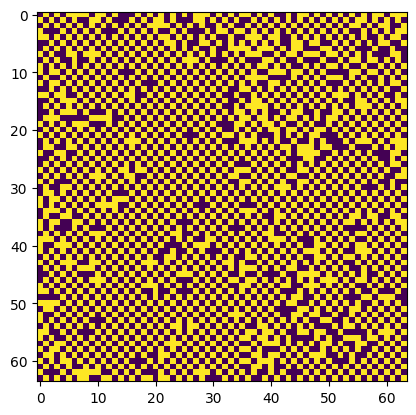

In [214]:
plt.imshow(X_train_anti[30])
print("Class:", y_train_anti[30])
print("Temperature:", Y_train_anti[30])

#### Fully Connected Neural Network

In [ ]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [ ]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# # Dataset 1, NN -> antiFe, NNN -> Fe
# X_anti, y_anti, Y_anti = full_file_loader('data_anti.npz')
# dataset_anti = IsingDataset(X_anti, y_anti)
# batch_size = 128
# dataloader_anti = DataLoader(dataset = dataset_anti, batch_size = batch_size, shuffle = False)

In [ ]:
train(FCNN, 10, criterion_FCNN, optimizer_FCNN, train_dataloader_anti)

Loss: 0.694808840751648 ,Train accuracy: 0.6015625
Loss: 0.6998928785324097 ,Train accuracy: 0.4765625
Loss: 0.6956212520599365 ,Train accuracy: 0.703125
Loss: 0.6933309435844421 ,Train accuracy: 0.5390625
Loss: 0.6729944348335266 ,Train accuracy: 0.546875
Loss: 0.6664677858352661 ,Train accuracy: 0.79296875
Loss: 0.7108287215232849 ,Train accuracy: 0.49609375
Loss: 0.6884220838546753 ,Train accuracy: 0.75
Loss: 0.6801477670669556 ,Train accuracy: 0.57421875
Loss: 0.6276676654815674 ,Train accuracy: 0.8671875
Loss: 0.6431004405021667 ,Train accuracy: 0.7734375
Loss: 0.6468219757080078 ,Train accuracy: 0.75390625
Loss: 0.6360934972763062 ,Train accuracy: 0.7890625
Loss: 0.601184606552124 ,Train accuracy: 0.8125
Loss: 0.566032886505127 ,Train accuracy: 0.8671875
Loss: 0.6966426372528076 ,Train accuracy: 0.79296875
Loss: 0.6068639159202576 ,Train accuracy: 0.80859375
Loss: 0.5976171493530273 ,Train accuracy: 0.8203125
Loss: 0.570264995098114 ,Train accuracy: 0.83203125
Loss: 0.52796196937

In [ ]:
test(FCNN, criterion_FCNN, test_dataloader_anti)

0 :: Loss: 0.1944330930709839 ,Test accuracy: 0.9296875
1 :: Loss: 0.3490474820137024 ,Test accuracy: 0.87890625
2 :: Loss: 0.2394697368144989 ,Test accuracy: 0.93359375
3 :: Loss: 0.3447885811328888 ,Test accuracy: 0.90625
4 :: Loss: 0.3742731213569641 ,Test accuracy: 0.890625
5 :: Loss: 0.1726294755935669 ,Test accuracy: 0.9375
6 :: Loss: 0.37815940380096436 ,Test accuracy: 0.89453125
7 :: Loss: 0.35600364208221436 ,Test accuracy: 0.890625
8 :: Loss: 0.22086834907531738 ,Test accuracy: 0.90625
9 :: Loss: 0.38123810291290283 ,Test accuracy: 0.875
10 :: Loss: 0.22011587023735046 ,Test accuracy: 0.9375
11 :: Loss: 0.39048415422439575 ,Test accuracy: 0.8671875
12 :: Loss: 0.5222269296646118 ,Test accuracy: 0.8671875
13 :: Loss: 0.22922751307487488 ,Test accuracy: 0.91015625
14 :: Loss: 0.31962859630584717 ,Test accuracy: 0.875
15 :: Loss: 0.3035730719566345 ,Test accuracy: 0.9296875
16 :: Loss: 0.4342727065086365 ,Test accuracy: 0.86328125
17 :: Loss: 0.3147673010826111 ,Test accuracy: 0

#### CNN:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet_for(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [ ]:
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [ ]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader_anti)

Loss: 0.7100217342376709 ,Train accuracy: 0.484375
Loss: 0.057843998074531555 ,Train accuracy: 0.9765625
Loss: 0.012487726286053658 ,Train accuracy: 1.0
Loss: 0.03287152573466301 ,Train accuracy: 0.9921875
Loss: 0.04040445759892464 ,Train accuracy: 0.984375
Loss: 0.030561193823814392 ,Train accuracy: 0.9921875
Loss: 0.034744761884212494 ,Train accuracy: 0.9921875
Loss: 0.04713290184736252 ,Train accuracy: 0.984375
Loss: 0.009999068453907967 ,Train accuracy: 1.0
Loss: 0.08652787655591965 ,Train accuracy: 0.9765625
Loss: 0.02554647997021675 ,Train accuracy: 0.9921875
Loss: 0.010590054094791412 ,Train accuracy: 1.0
Loss: 0.04072888195514679 ,Train accuracy: 0.9765625
Loss: 0.033530235290527344 ,Train accuracy: 0.984375
Loss: 0.05009687319397926 ,Train accuracy: 0.984375
Loss: 0.025378115475177765 ,Train accuracy: 0.984375
Loss: 0.030058570206165314 ,Train accuracy: 0.9921875
Loss: 0.03169341757893562 ,Train accuracy: 0.9921875
Loss: 0.04334889352321625 ,Train accuracy: 0.9765625
Loss: 0.0

In [ ]:
test(CNN, criterion_CNN, test_dataloader_anti)

0 :: Loss: 0.013246769085526466 ,Test accuracy: 1.0
1 :: Loss: 0.006145419552922249 ,Test accuracy: 1.0
2 :: Loss: 0.10438580811023712 ,Test accuracy: 0.96875
3 :: Loss: 0.013369170017540455 ,Test accuracy: 0.9921875
4 :: Loss: 0.055634912103414536 ,Test accuracy: 0.9765625
5 :: Loss: 0.03210558369755745 ,Test accuracy: 0.9921875
6 :: Loss: 0.026198744773864746 ,Test accuracy: 0.9921875
7 :: Loss: 0.0072803618386387825 ,Test accuracy: 1.0
8 :: Loss: 0.05747205391526222 ,Test accuracy: 0.9921875
9 :: Loss: 0.016055766493082047 ,Test accuracy: 0.9921875
10 :: Loss: 0.020776154473423958 ,Test accuracy: 0.9921875
11 :: Loss: 0.005502460524439812 ,Test accuracy: 1.0
12 :: Loss: 0.015774372965097427 ,Test accuracy: 0.984375
13 :: Loss: 0.014016851782798767 ,Test accuracy: 0.9921875
14 :: Loss: 0.004771659150719643 ,Test accuracy: 1.0
15 :: Loss: 0.0187583826482296 ,Test accuracy: 0.9921875
16 :: Loss: 0.01748012937605381 ,Test accuracy: 0.984375
17 :: Loss: 0.18451344966888428 ,Test accuracy

In [ ]:
torch.save(CNN.state_dict(), 'CNN_anti.pth')

### CNN 2

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet2(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=0)
        self.max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.out_conv2 = self._calculate_output_size(self.out_conv1, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(9216, 64)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = self.max_pool_layer(F.relu(self.conv1(x)))
        x = self.max_pool_layer(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

# Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

# Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [223]:
CNN_2 = ConvNet2(Nx, Ny).to(device)
criterion_CNN_2 = nn.BCELoss()
optimizer_CNN_2 = optim.Adam(CNN_2.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [224]:
train(CNN_2, 10, criterion_CNN_2, optimizer_CNN_2, train_dataloader_anti)

Loss: 0.7168821096420288 ,Train accuracy: 0.3984375
Loss: 0.36896973848342896 ,Train accuracy: 0.9453125
Loss: 0.06387653201818466 ,Train accuracy: 1.0
Loss: 0.060284633189439774 ,Train accuracy: 0.9921875
Loss: 0.07027247548103333 ,Train accuracy: 0.96875
Loss: 0.01832224428653717 ,Train accuracy: 0.9921875
Loss: 0.02653094194829464 ,Train accuracy: 0.9921875
Loss: 0.026200830936431885 ,Train accuracy: 0.9921875
Loss: 0.00790325552225113 ,Train accuracy: 1.0
Loss: 0.011764061637222767 ,Train accuracy: 0.9921875
Loss: 0.008189396932721138 ,Train accuracy: 1.0
Loss: 0.00761816743761301 ,Train accuracy: 1.0
Loss: 0.03752874583005905 ,Train accuracy: 0.9921875
Loss: 0.03546338528394699 ,Train accuracy: 0.984375
Loss: 0.0018826620653271675 ,Train accuracy: 1.0
Loss: 0.017355136573314667 ,Train accuracy: 0.9921875
Loss: 0.011657326482236385 ,Train accuracy: 0.9921875
Loss: 0.003046018537133932 ,Train accuracy: 1.0
Loss: 0.004044950939714909 ,Train accuracy: 1.0
Loss: 0.009651491418480873 ,T

In [225]:
test(CNN_2, criterion_CNN_2, test_dataloader_anti)

0 :: Loss: 0.0032722498290240765 ,Test accuracy: 1.0
1 :: Loss: 0.012424340471625328 ,Test accuracy: 0.9921875
2 :: Loss: 0.016427651047706604 ,Test accuracy: 0.9921875
3 :: Loss: 0.0033397236838936806 ,Test accuracy: 1.0
4 :: Loss: 0.03973354771733284 ,Test accuracy: 0.9921875
5 :: Loss: 0.012417104095220566 ,Test accuracy: 0.9921875
6 :: Loss: 0.011403960175812244 ,Test accuracy: 0.9921875
7 :: Loss: 0.00408575963228941 ,Test accuracy: 1.0
8 :: Loss: 0.0022109674755483866 ,Test accuracy: 1.0
9 :: Loss: 0.006072656251490116 ,Test accuracy: 1.0
10 :: Loss: 0.001976446248590946 ,Test accuracy: 1.0
11 :: Loss: 0.000466781435534358 ,Test accuracy: 1.0
12 :: Loss: 0.00372714689001441 ,Test accuracy: 1.0
13 :: Loss: 0.007336121052503586 ,Test accuracy: 1.0
14 :: Loss: 0.0020149771589785814 ,Test accuracy: 1.0
15 :: Loss: 0.0006037766579538584 ,Test accuracy: 1.0
16 :: Loss: 0.02781914547085762 ,Test accuracy: 0.984375
17 :: Loss: 0.013317417353391647 ,Test accuracy: 0.9921875
18 :: Loss: 0.

In [226]:
torch.save(CNN_2.state_dict(), 'CNN_anti.pth')

### Feature Maps

In [ ]:
# Example Usage:
# model = ConvNet(40, 40)
def plot_feature_map(model, x, y, print_data = False):
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = model(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  print(data)
  plt.imshow(data)
  plt.colorbar()
  plt.title(f'Temperature={y}')
  plt.show()

Text(0.5, 1.0, 'Temperature=1.0')

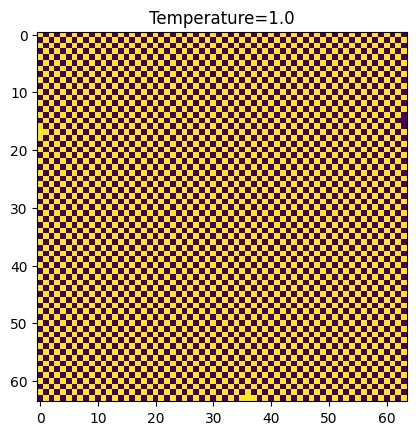

In [ ]:
plt.imshow(X_train_anti[0])
plt.title(f"Temperature={Y_train_anti[0]}")

[[1.0353074  0.         0.         ... 0.         1.0353074  0.5947193 ]
 [0.         0.         1.0353074  ... 1.0353074  0.         0.12124181]
 [1.0353074  0.5947193  0.         ... 0.         1.0353074  0.        ]
 ...
 [1.0353074  0.         1.0353074  ... 0.43821007 0.5947193  0.12593082]
 [0.27775103 0.43821007 0.         ... 0.12124181 0.         0.56651884]
 [0.         0.         1.0353074  ... 0.         0.56651884 1.1918166 ]]


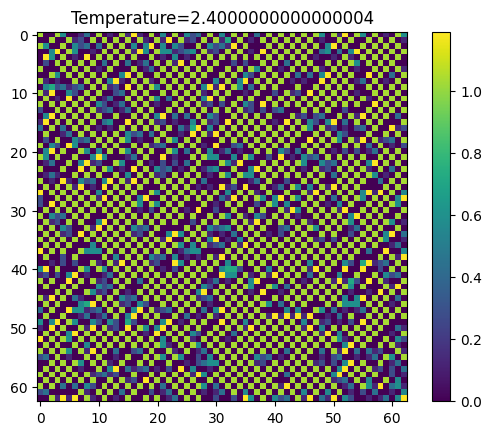

In [ ]:
plot_feature_map(CNN, X_train_anti[2000], Y_train_anti[2000])

### Test on the R = +2 data

###### Loading the datasets and the trained model

In [ ]:
X2, y2, Y2 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2.npz', 4.5)

FileNotFoundError: [Errno 2] No such file or directory: 'data_64NNN_anti_noshuffle_Rplus2.npz'

In [ ]:
dataset2 = IsingDataset(X2, y2)
batch_size = 128
dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)

###### CNN

In [ ]:
dataset2.__len__()

In [ ]:
test(CNN, criterion_CNN, dataloader2)

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader2, CNN)

In [ ]:
plt.scatter(Y2, pred_class1, label='Antiferromagnetic')
plt.scatter(Y2, pred_class2, label='Paramagnetic')
plt.legend()

###### Visualization

In [ ]:
plt.imshow(X2[1600])
plt.title(f"Temperature={Y2[1600]}")

In [ ]:
plot_feature_map(CNN, X2[1600], Y2[1600])

In [ ]:
plt.imshow(X2[0])
plt.title(f"Temperature={Y2[0]}")

In [ ]:
  x = X2[8]
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = CNN(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  data

In [ ]:
plot_feature_map(CNN, X2[0], Y2[0], print_data = True)

### Testing on the second (best) R=+2 data

###### Loading the datasets and the trained model

In [ ]:
X1, y1, Y1 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [ ]:
dataset1 = IsingDataset(X1, y1)
batch_size = 128
dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)

<ipython-input-13-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-13-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


###### CNN

In [ ]:
dataset1.__len__()

1200

In [ ]:
test(CNN, criterion_CNN, dataloader1)

0 :: Loss: 80.99919891357422 ,Test accuracy: 0.0
1 :: Loss: 79.13746643066406 ,Test accuracy: 0.0
2 :: Loss: 79.6487808227539 ,Test accuracy: 0.0
3 :: Loss: 68.9416275024414 ,Test accuracy: 0.09375
4 :: Loss: 8.086458169742627e-10 ,Test accuracy: 1.0
5 :: Loss: 5.413834745088275e-12 ,Test accuracy: 1.0
6 :: Loss: 2.4169603818346985e-11 ,Test accuracy: 1.0
7 :: Loss: 1.1480339026093134e-06 ,Test accuracy: 1.0
8 :: Loss: 5.048984235145326e-07 ,Test accuracy: 1.0
9 :: Loss: 2.1734255020722237e-12 ,Test accuracy: 1.0


In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader1, CNN)

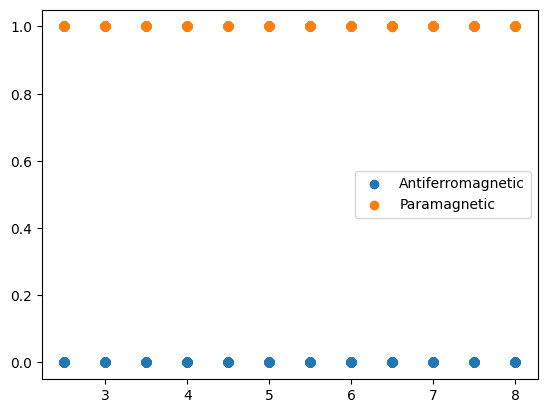

In [ ]:
plt.scatter(Y1, pred_class1, label='Antiferromagnetic')
plt.scatter(Y1, pred_class2, label='Paramagnetic')
plt.legend()

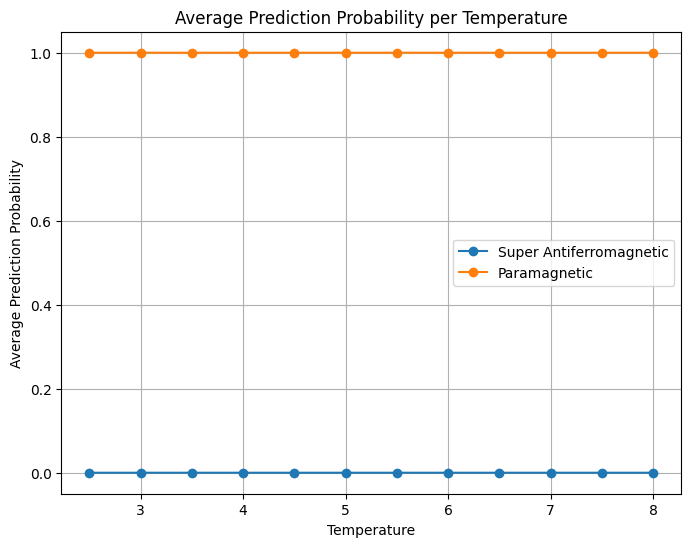

In [ ]:
plot_proba(np.array(Y1), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

### Transfer Learning

#### Loading the Dataset

Full Data

In [227]:
file1 = 'data_64NNN_anti_noshuffle_Rplus2_best3.npz'
file2 = 'data_64NNN_anti_noshuffle_Rplus2_best4.npz'
combined_file = 'data_64NNN_anti_noshuffle_Rplus2_best34.npz'

combine_npz_files(file1, file2, combined_file)


In [228]:
X1, y1, Y1 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [229]:
dataset1 = IsingDataset(X1, y1)
batch_size = 128
dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [230]:
X2, y2, Y2 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best2.npz', 4.5)

In [231]:
dataset2 = IsingDataset(X2, y2)
batch_size = 128
dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [232]:
X3, y3, Y3 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best3.npz', 4.5)

In [233]:
dataset3 = IsingDataset(X3, y3)
batch_size = 128
dataloader3 = DataLoader(dataset = dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [234]:
X34, y34, Y34 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best34.npz', 4.5)

In [235]:
dataset34 = IsingDataset(X34, y34)
batch_size = 128
dataloader34 = DataLoader(dataset = dataset34, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Train and test data

In [236]:
X_train1, X_test1, y_train1, y_test1, Y_train1, Y_test1 = file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [237]:
training_dataset1 = IsingDataset(X_train1, y_train1)
testing_dataset1 = IsingDataset(X_test1, y_test1)
batch_size = 128
train_dataloader1 = DataLoader(dataset = training_dataset1, batch_size = batch_size, shuffle = False)
test_dataloader1 = DataLoader(dataset = testing_dataset1, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [238]:
X_train2, X_test2, y_train2, y_test2, Y_train2, Y_test2 = file_loader('data_64NNN_anti_noshuffle_Rplus2_best2.npz', 4.5)

In [239]:
training_dataset2 = IsingDataset(X_train2, y_train2)
testing_dataset2 = IsingDataset(X_test2, y_test2)
batch_size = 128
train_dataloader2 = DataLoader(dataset = training_dataset2, batch_size = batch_size, shuffle = False)
test_dataloader2 = DataLoader(dataset = testing_dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Combined Data

In [240]:
# Create the combined dataset
combined_dataset_wo_aug12 = create_combined_dataset(dataset1, dataset2)

# Create a new DataLoader for the combined dataset
combined_dataloader_wo_aug12 = DataLoader(dataset = combined_dataset_wo_aug12, batch_size=batch_size, shuffle=False)

In [241]:
# Create the combined dataset
combined_dataset_wo_aug123 = create_combined_dataset(combined_dataset_wo_aug12, dataset3)

# Create a new DataLoader for the combined dataset
combined_dataloader_wo_aug123 = DataLoader(dataset = combined_dataset_wo_aug123, batch_size=batch_size, shuffle=False)

In [242]:
# Create the combined dataset
combined_dataset_wo_aug1234 = create_combined_dataset(combined_dataset_wo_aug12, dataset34)

# Create a new DataLoader for the combined dataset
combined_dataloader_wo_aug1234 = DataLoader(dataset = combined_dataset_wo_aug1234, batch_size=batch_size, shuffle=False)

Augmented data

In [243]:
# Assuming you already have an original DataLoader named original_dataloader
# You can get the original dataset from original_dataloader.dataset
original_dataset1 = dataloader1.dataset

# Create the combined dataset
combined_dataset1 = create_combined_dataset_with_augmentation(original_dataset1)


# Create a new DataLoader for the combined dataset
combined_dataloader1 = DataLoader(dataset = combined_dataset1, batch_size=dataloader1.batch_size, shuffle=False)

# Now, new_dataloader contains both the original data and the 90-degree rotated data, with labels unchanged


In [244]:
# Assuming you already have an original DataLoader named original_dataloader
# You can get the original dataset from original_dataloader.dataset
original_dataset2 = dataloader2.dataset

# Create the combined dataset
combined_dataset2 = create_combined_dataset_with_augmentation(original_dataset2)


# Create a new DataLoader for the combined dataset
combined_dataloader2 = DataLoader(dataset = combined_dataset2, batch_size=dataloader2.batch_size, shuffle=False)

# Now, new_dataloader contains both the original data and the 90-degree rotated data, with labels unchanged


In [245]:
# Assuming you already have an original DataLoader named original_dataloader
# You can get the original dataset from original_dataloader.dataset
comb_dataset1 = combined_dataloader1.dataset
comb_dataset2 = combined_dataloader2.dataset

# Create the combined dataset
combined_dataset = create_combined_dataset(comb_dataset2, comb_dataset1)

# Create a new DataLoader for the combined dataset
combined_dataloader = DataLoader(dataset = combined_dataset, batch_size=combined_dataloader2.batch_size, shuffle=False)

# Now, new_dataloader contains both the original data and the 90-degree rotated data, with labels unchanged


#### Training a model to compare the results

In [246]:
import torch
import torch.nn as nn
import torch.optim as optim

CNN2 = ConvNet2(Nx, Ny)
CNN2.to(device)

# Setup optimizer
optimizer = optim.Adam(CNN2.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()

# Example usage of the training function with dataloader8
train(CNN2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)
# train(CNN2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=dataset34)

Loss: 0.7087637186050415 ,Train accuracy: 0.3515625
Loss: 0.71278977394104 ,Train accuracy: 0.3046875
Loss: 0.6556894183158875 ,Train accuracy: 1.0
Loss: 0.7358809113502502 ,Train accuracy: 0.0
Loss: 0.2921105623245239 ,Train accuracy: 1.0
Loss: 0.7430962324142456 ,Train accuracy: 0.265625
Loss: 0.581832766532898 ,Train accuracy: 1.0
Loss: 0.7369952201843262 ,Train accuracy: 0.0
Loss: 0.06315867602825165 ,Train accuracy: 1.0
Loss: 0.5313315987586975 ,Train accuracy: 1.0
Loss: 0.4114747941493988 ,Train accuracy: 1.0
Loss: 0.20065195858478546 ,Train accuracy: 1.0
Loss: 0.0004465975216589868 ,Train accuracy: 1.0
Loss: 0.39341509342193604 ,Train accuracy: 1.0
Loss: 0.4250044822692871 ,Train accuracy: 1.0
Loss: 0.08020617812871933 ,Train accuracy: 1.0
Loss: 0.004462680779397488 ,Train accuracy: 1.0
Loss: 0.4195833206176758 ,Train accuracy: 1.0
Loss: 0.4059644341468811 ,Train accuracy: 1.0
Loss: 0.007048087194561958 ,Train accuracy: 1.0
Loss: 0.0013013442512601614 ,Train accuracy: 1.0
Loss: 

In [247]:
test(CNN2, criterion, combined_dataloader_wo_aug1234)

0 :: Loss: 0.0005503655411303043 ,Test accuracy: 1.0
1 :: Loss: 0.0006276446511037648 ,Test accuracy: 1.0
2 :: Loss: 0.0008073901990428567 ,Test accuracy: 1.0
3 :: Loss: 1.027132272720337 ,Test accuracy: 0.328125
4 :: Loss: 0.3165457844734192 ,Test accuracy: 1.0
5 :: Loss: 0.37014660239219666 ,Test accuracy: 1.0
6 :: Loss: 0.32302558422088623 ,Test accuracy: 1.0
7 :: Loss: 0.3260456323623657 ,Test accuracy: 1.0
8 :: Loss: 0.3700413107872009 ,Test accuracy: 1.0
9 :: Loss: 0.11213425546884537 ,Test accuracy: 1.0
10 :: Loss: 0.0007285010069608688 ,Test accuracy: 1.0
11 :: Loss: 0.00024430511984974146 ,Test accuracy: 1.0
12 :: Loss: 0.00030260597122833133 ,Test accuracy: 1.0
13 :: Loss: 0.00034434255212545395 ,Test accuracy: 1.0
14 :: Loss: 0.002982686273753643 ,Test accuracy: 1.0
15 :: Loss: 0.43893787264823914 ,Test accuracy: 0.6875
16 :: Loss: 0.9646375179290771 ,Test accuracy: 0.3359375
17 :: Loss: 0.4450211524963379 ,Test accuracy: 0.875
18 :: Loss: 0.3259856402873993 ,Test accuracy: 

In [248]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, CNN2)

In [249]:
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape

(9000,)

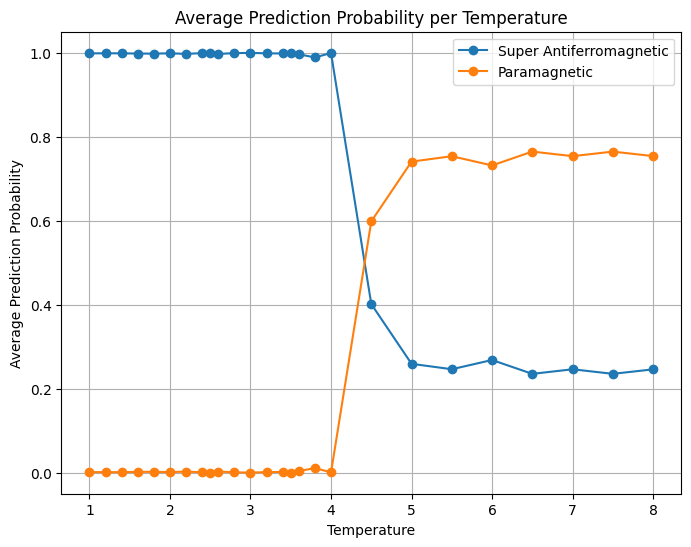

In [250]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

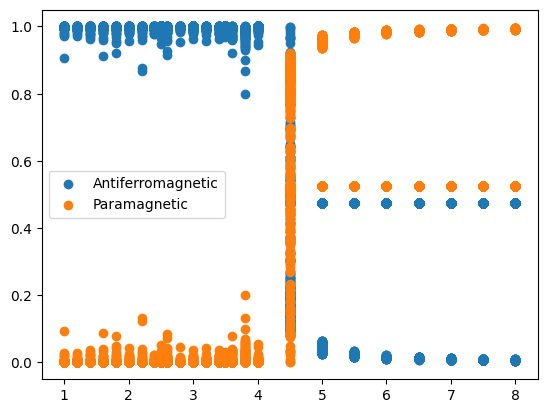

In [251]:
plt.scatter(Y_comb1234, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

In [252]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])

In [253]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.9558888888888889

#### Transfer learning on NNN R=+2 data, model pre-trained on Ferro NN

##### Both weights not initialized:

In [206]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
# model2.fc1.weight.data = pretrained_model.fc1.weight.data
# model2.fc1.bias.data = pretrained_model.fc1.bias.data

# model2.fc2.weight.data = pretrained_model.fc2.weight.data
# model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=2*1e-5/3, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 0.669964075088501 ,Train accuracy: 0.6171875
Loss: 0.8070818185806274 ,Train accuracy: 0.1796875
Loss: 0.5867452025413513 ,Train accuracy: 0.828125
Loss: 0.8134491443634033 ,Train accuracy: 0.078125
Loss: 0.6873834133148193 ,Train accuracy: 0.5390625
Loss: 0.871178388595581 ,Train accuracy: 0.0859375
Loss: 0.684418797492981 ,Train accuracy: 0.546875
Loss: 0.7639708518981934 ,Train accuracy: 0.2265625
Loss: 0.6513229608535767 ,Train accuracy: 0.8359375
Loss: 0.8792939186096191 ,Train accuracy: 0.03125
Loss: 0.680832028388977 ,Train accuracy: 0.5546875
Loss: 0.7599287033081055 ,Train accuracy: 0.1328125
Loss: 0.6516740322113037 ,Train accuracy: 0.8125
Loss: 0.8820439577102661 ,Train accuracy: 0.03125
Loss: 0.7040258646011353 ,Train accuracy: 0.4296875
Loss: 0.7459135055541992 ,Train accuracy: 0.140625
Loss: 0.6488679051399231 ,Train accuracy: 0.84375
Loss: 0.8664901256561279 ,Train accuracy: 0.015625
Loss: 0.7143268585205078 ,Train accuracy: 0.421875
Loss: 0.7338312864303589 ,Train

In [207]:
# test(model2, criterion, combined_dataloader_wo_aug123)

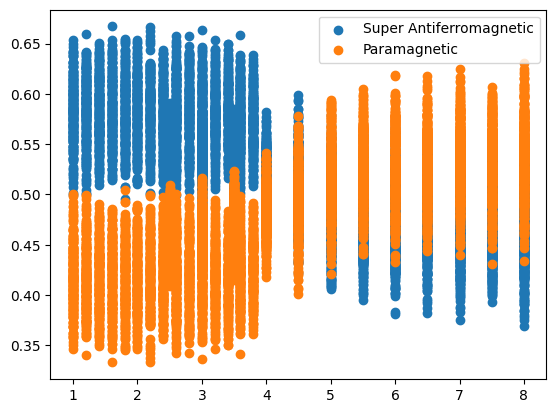

In [208]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

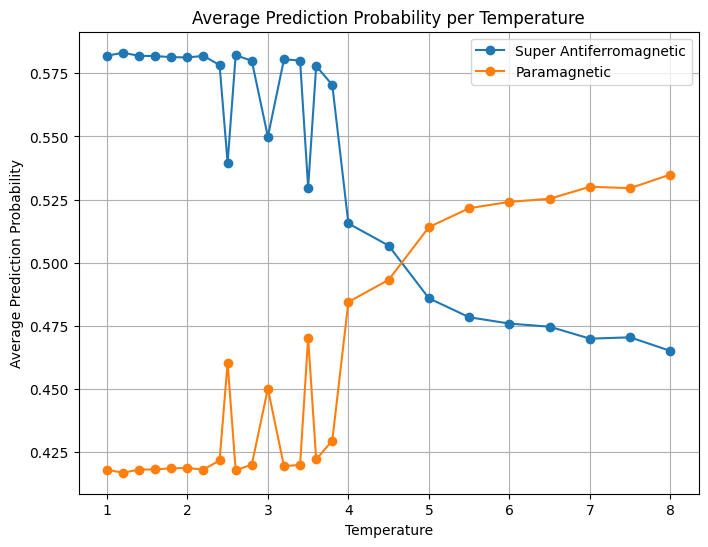

In [209]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [210]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])

In [211]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.8647777777777778

##### FC1 initialized:

In [145]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
model2.fc1.weight.data = pretrained_model.fc1.weight.data
model2.fc1.bias.data = pretrained_model.fc1.bias.data

# model2.fc2.weight.data = pretrained_model.fc2.weight.data
# model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-5, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 0.3252193033695221 ,Train accuracy: 0.84375
Loss: 6.728420257568359 ,Train accuracy: 0.15625
Loss: 7.263208389282227 ,Train accuracy: 0.1796875
Loss: 0.5315290093421936 ,Train accuracy: 0.8203125
Loss: 0.30252623558044434 ,Train accuracy: 0.859375
Loss: 5.411538124084473 ,Train accuracy: 0.1796875
Loss: 6.523975372314453 ,Train accuracy: 0.125
Loss: 0.5956862568855286 ,Train accuracy: 0.7421875
Loss: 0.6886919736862183 ,Train accuracy: 0.703125
Loss: 5.573484420776367 ,Train accuracy: 0.1875
Loss: 4.682222366333008 ,Train accuracy: 0.265625
Loss: 0.4567052721977234 ,Train accuracy: 0.828125
Loss: 0.5727660059928894 ,Train accuracy: 0.7421875
Loss: 4.162792205810547 ,Train accuracy: 0.28125
Loss: 3.951272487640381 ,Train accuracy: 0.265625
Loss: 0.8096939325332642 ,Train accuracy: 0.71875
Loss: 0.6986503005027771 ,Train accuracy: 0.6875
Loss: 3.5992417335510254 ,Train accuracy: 0.34375
Loss: 3.619255542755127 ,Train accuracy: 0.328125
Loss: 0.681533694267273 ,Train accuracy: 0.757

In [146]:
# test(model2, criterion, combined_dataloader_wo_aug123)

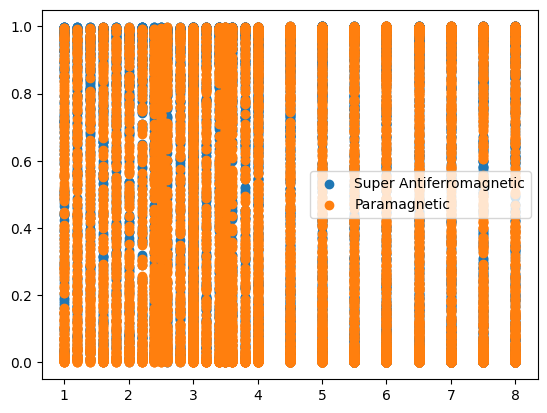

In [147]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

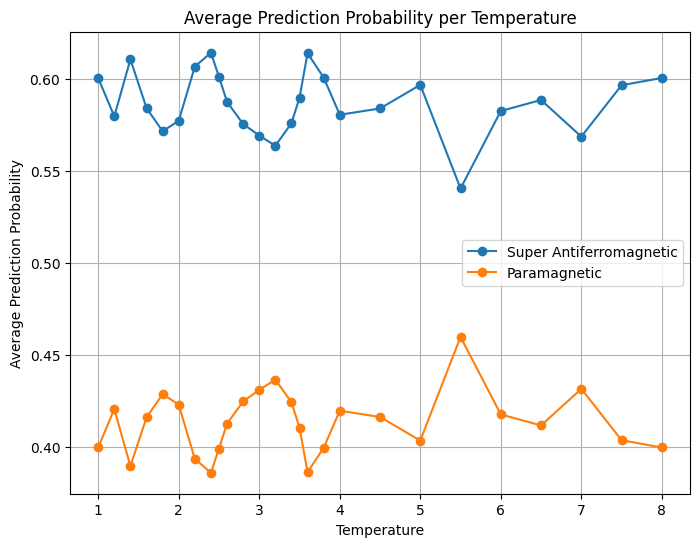

In [148]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [149]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])

In [151]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.5282222222222223

##### FC2 initialized:

In [200]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
# model2.fc1.weight.data = pretrained_model.fc1.weight.data
# model2.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=2*1e-5/3, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 0.6664539575576782 ,Train accuracy: 0.671875
Loss: 0.7519176006317139 ,Train accuracy: 0.2890625
Loss: 0.564228892326355 ,Train accuracy: 0.890625
Loss: 0.7794514894485474 ,Train accuracy: 0.2109375
Loss: 0.6863716244697571 ,Train accuracy: 0.5703125
Loss: 0.7737933397293091 ,Train accuracy: 0.2109375
Loss: 0.6873551607131958 ,Train accuracy: 0.5625
Loss: 0.7264801263809204 ,Train accuracy: 0.296875
Loss: 0.6476452350616455 ,Train accuracy: 0.8359375
Loss: 0.8011503219604492 ,Train accuracy: 0.1171875
Loss: 0.7029789686203003 ,Train accuracy: 0.4609375
Loss: 0.7055481672286987 ,Train accuracy: 0.4140625
Loss: 0.6415096521377563 ,Train accuracy: 0.890625
Loss: 0.8187271952629089 ,Train accuracy: 0.0859375
Loss: 0.7014957666397095 ,Train accuracy: 0.53125
Loss: 0.6977579593658447 ,Train accuracy: 0.4765625
Loss: 0.6426019668579102 ,Train accuracy: 0.9140625
Loss: 0.7967057824134827 ,Train accuracy: 0.109375
Loss: 0.6991418600082397 ,Train accuracy: 0.53125
Loss: 0.6987473964691162 

In [201]:
# test(model2, criterion, combined_dataloader_wo_aug123)

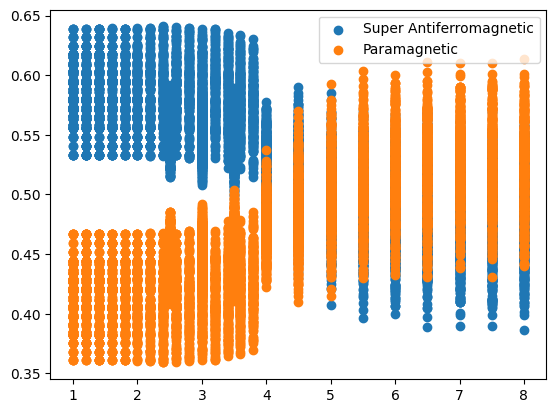

In [202]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

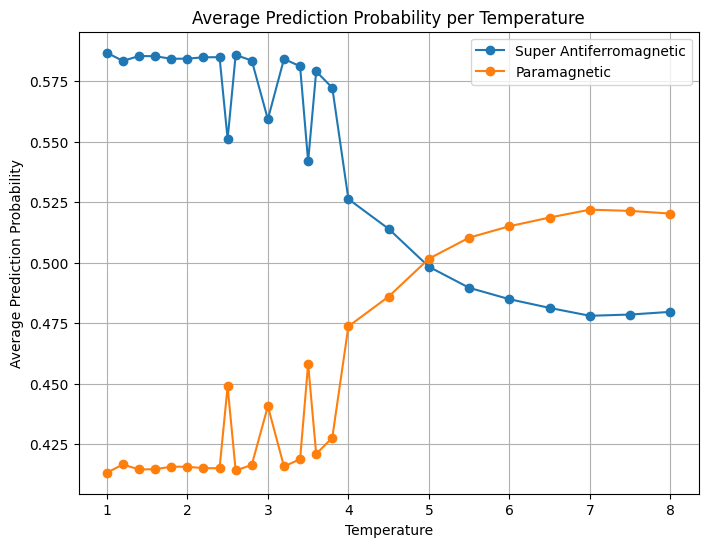

In [203]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [204]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])

In [205]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.8467777777777777

##### Both weights initialized:

In [171]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
model2.fc1.weight.data = pretrained_model.fc1.weight.data
model2.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-7, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 34.879730224609375 ,Train accuracy: 0.0
Loss: 2.6891951776519818e-08 ,Train accuracy: 1.0
Loss: 1.0518593107633478e-08 ,Train accuracy: 1.0
Loss: 49.92720031738281 ,Train accuracy: 0.0
Loss: 36.963623046875 ,Train accuracy: 0.0
Loss: 7.690487358047449e-09 ,Train accuracy: 1.0
Loss: 1.3905582463280552e-08 ,Train accuracy: 1.0
Loss: 48.68603515625 ,Train accuracy: 0.0
Loss: 33.277320861816406 ,Train accuracy: 0.0
Loss: 1.338432724651284e-07 ,Train accuracy: 1.0
Loss: 2.5409028125977784e-07 ,Train accuracy: 1.0
Loss: 48.801605224609375 ,Train accuracy: 0.0
Loss: 37.43778991699219 ,Train accuracy: 0.0
Loss: 4.723554880570191e-09 ,Train accuracy: 1.0
Loss: 2.4512096796769356e-09 ,Train accuracy: 1.0
Loss: 48.42644500732422 ,Train accuracy: 0.0
Loss: 36.893497467041016 ,Train accuracy: 0.0
Loss: 1.7887636261093576e-08 ,Train accuracy: 1.0
Loss: 4.5975173668111324e-10 ,Train accuracy: 1.0
Loss: 46.302181243896484 ,Train accuracy: 0.0
Loss: 35.03947067260742 ,Train accuracy: 0.0
Loss: 4.

In [172]:
# test(model2, criterion, combined_dataloader_wo_aug123)

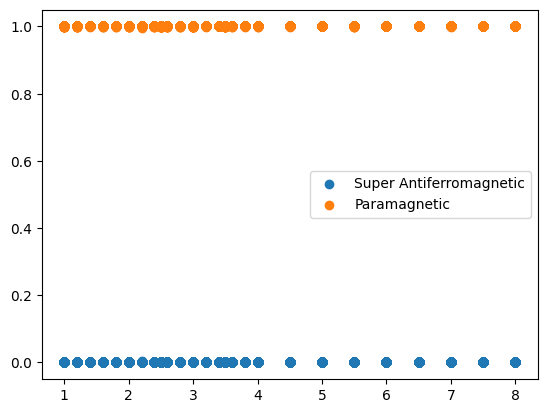

In [173]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

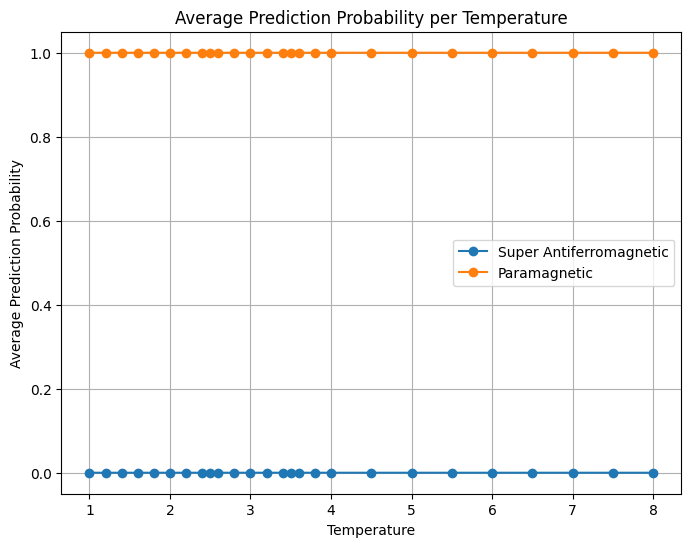

In [174]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [175]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])

In [176]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.3888888888888889

#### Transfer learning on NNN R=+2 data, model pre-trained on anti-ferro NN

##### Both weights not initialized:

In [254]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
# model2.fc1.weight.data = pretrained_model.fc1.weight.data
# model2.fc1.bias.data = pretrained_model.fc1.bias.data

# model2.fc2.weight.data = pretrained_model.fc2.weight.data
# model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-5, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 0.8589515686035156 ,Train accuracy: 0.0
Loss: 0.5537881851196289 ,Train accuracy: 0.96875
Loss: 0.364601194858551 ,Train accuracy: 1.0
Loss: 0.934319257736206 ,Train accuracy: 0.0
Loss: 0.7066973447799683 ,Train accuracy: 0.3828125
Loss: 0.8212700486183167 ,Train accuracy: 0.1640625
Loss: 0.7348287105560303 ,Train accuracy: 0.265625
Loss: 0.7046307921409607 ,Train accuracy: 0.375
Loss: 0.7060668468475342 ,Train accuracy: 0.3515625
Loss: 0.8048971891403198 ,Train accuracy: 0.0703125
Loss: 0.7224994897842407 ,Train accuracy: 0.25
Loss: 0.7107723355293274 ,Train accuracy: 0.203125
Loss: 0.7113320827484131 ,Train accuracy: 0.25
Loss: 0.7770602703094482 ,Train accuracy: 0.1328125
Loss: 0.7164524793624878 ,Train accuracy: 0.28125
Loss: 0.7125269174575806 ,Train accuracy: 0.21875
Loss: 0.7118133902549744 ,Train accuracy: 0.21875
Loss: 0.768667459487915 ,Train accuracy: 0.1640625
Loss: 0.7112504243850708 ,Train accuracy: 0.390625
Loss: 0.71834397315979 ,Train accuracy: 0.1171875
Loss: 0.

In [255]:
# test(model2, criterion, combined_dataloader_wo_aug123)

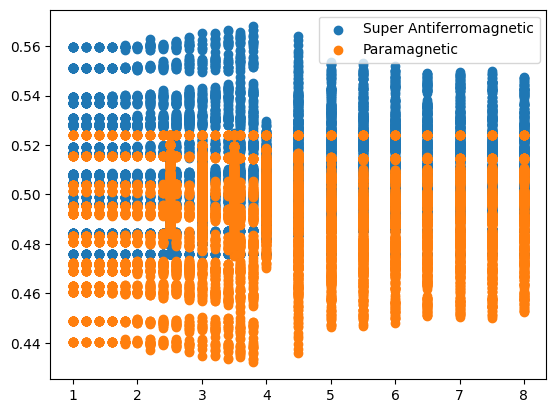

In [256]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

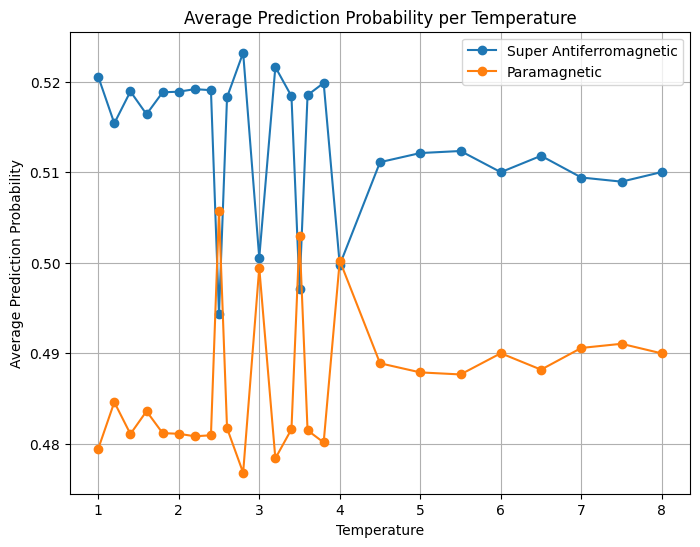

In [257]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [258]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.48966666666666664

##### FC1 initialized:

In [259]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
model2.fc1.weight.data = pretrained_model.fc1.weight.data
model2.fc1.bias.data = pretrained_model.fc1.bias.data

# model2.fc2.weight.data = pretrained_model.fc2.weight.data
# model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-5, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 1.7577176094055176 ,Train accuracy: 0.3984375
Loss: 3.3432605266571045 ,Train accuracy: 0.5546875
Loss: 4.520652770996094 ,Train accuracy: 0.5625
Loss: 3.794935703277588 ,Train accuracy: 0.46875
Loss: 1.5295745134353638 ,Train accuracy: 0.4453125
Loss: 4.0857391357421875 ,Train accuracy: 0.5234375
Loss: 4.849842071533203 ,Train accuracy: 0.46875
Loss: 2.5328986644744873 ,Train accuracy: 0.4921875
Loss: 1.2486519813537598 ,Train accuracy: 0.5078125
Loss: 6.347267150878906 ,Train accuracy: 0.46875
Loss: 7.1332879066467285 ,Train accuracy: 0.421875
Loss: 3.043121337890625 ,Train accuracy: 0.484375
Loss: 0.999308168888092 ,Train accuracy: 0.59375
Loss: 5.3627166748046875 ,Train accuracy: 0.4609375
Loss: 6.105401992797852 ,Train accuracy: 0.421875
Loss: 2.3451988697052 ,Train accuracy: 0.578125
Loss: 1.2522830963134766 ,Train accuracy: 0.578125
Loss: 6.421718597412109 ,Train accuracy: 0.359375
Loss: 5.777164459228516 ,Train accuracy: 0.40625
Loss: 1.979531168937683 ,Train accuracy: 0.

In [260]:
# test(model2, criterion, combined_dataloader_wo_aug123)

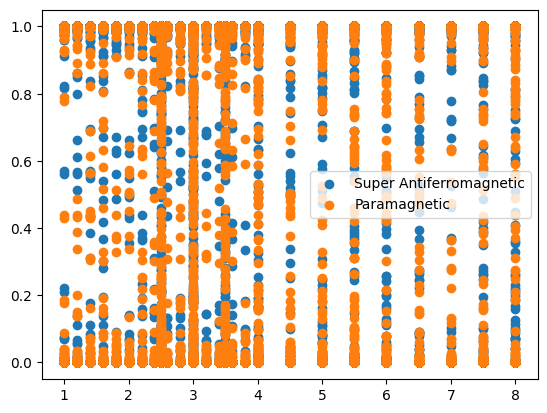

In [261]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

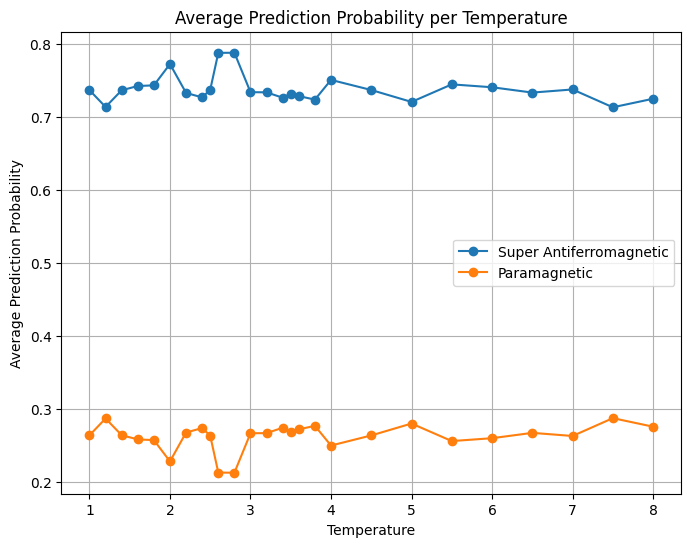

In [262]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [263]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.558

##### FC2 initialized:

In [289]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
# model2.fc1.weight.data = pretrained_model.fc1.weight.data
# model2.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-5/3, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=70, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 0.5062700510025024 ,Train accuracy: 0.9921875
Loss: 1.1867932081222534 ,Train accuracy: 0.0546875
Loss: 0.7735477685928345 ,Train accuracy: 0.40625
Loss: 0.7219667434692383 ,Train accuracy: 0.4453125
Loss: 0.5950598120689392 ,Train accuracy: 0.921875
Loss: 0.9013221263885498 ,Train accuracy: 0.2109375
Loss: 0.6648874878883362 ,Train accuracy: 0.640625
Loss: 0.7592564225196838 ,Train accuracy: 0.390625
Loss: 0.6206308603286743 ,Train accuracy: 0.8359375
Loss: 0.9252510070800781 ,Train accuracy: 0.1640625
Loss: 0.7077924013137817 ,Train accuracy: 0.5
Loss: 0.7433850169181824 ,Train accuracy: 0.3515625
Loss: 0.61122727394104 ,Train accuracy: 0.9296875
Loss: 0.9026467800140381 ,Train accuracy: 0.171875
Loss: 0.6752005815505981 ,Train accuracy: 0.6015625
Loss: 0.7286418676376343 ,Train accuracy: 0.3984375
Loss: 0.6207410097122192 ,Train accuracy: 0.8984375
Loss: 0.8594921827316284 ,Train accuracy: 0.21875
Loss: 0.6550908088684082 ,Train accuracy: 0.6328125
Loss: 0.7447348833084106 ,Tr

In [290]:
# test(model2, criterion, combined_dataloader_wo_aug123)

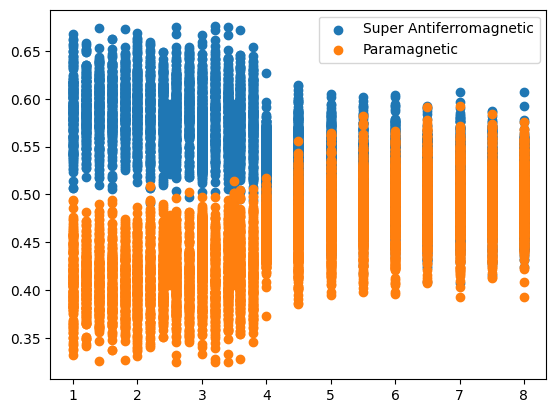

In [291]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

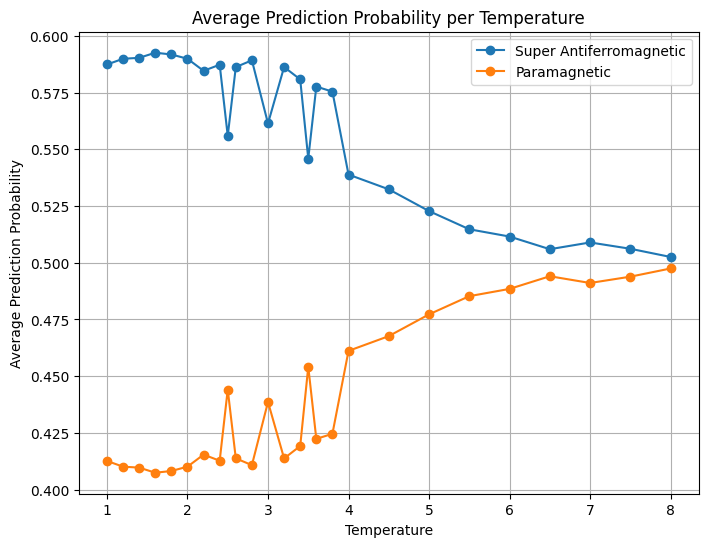

In [292]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [293]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.748

##### Both weights initialized:

In [269]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
model2.fc1.weight.data = pretrained_model.fc1.weight.data
model2.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
# model2.conv2.weight.requires_grad = True
# model2.conv2.bias.requires_grad = True
# model2.conv3.weight.requires_grad = True
# model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-5, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)


Loss: 16.381052017211914 ,Train accuracy: 0.0
Loss: 1.912575792184512e-10 ,Train accuracy: 1.0
Loss: 3.5055245461990125e-07 ,Train accuracy: 1.0
Loss: 58.75845718383789 ,Train accuracy: 0.0
Loss: 11.420127868652344 ,Train accuracy: 0.0
Loss: 5.454712592722899e-08 ,Train accuracy: 1.0
Loss: 1.7557391629452468e-07 ,Train accuracy: 1.0
Loss: 55.37006378173828 ,Train accuracy: 0.0
Loss: 9.237685203552246 ,Train accuracy: 0.0
Loss: 1.3476367257680977e-06 ,Train accuracy: 1.0
Loss: 2.0384179322263662e-07 ,Train accuracy: 1.0
Loss: 40.89344787597656 ,Train accuracy: 0.0
Loss: 7.355626106262207 ,Train accuracy: 0.0
Loss: 1.5650766727048904e-06 ,Train accuracy: 1.0
Loss: 1.129943143496348e-06 ,Train accuracy: 1.0
Loss: 26.180572509765625 ,Train accuracy: 0.0
Loss: 5.39231014251709 ,Train accuracy: 0.0
Loss: 0.00031172711169347167 ,Train accuracy: 1.0
Loss: 0.0005997316329739988 ,Train accuracy: 1.0
Loss: 14.727703094482422 ,Train accuracy: 0.0
Loss: 4.651775360107422 ,Train accuracy: 0.0
Loss: 

In [270]:
# test(model2, criterion, combined_dataloader_wo_aug123)

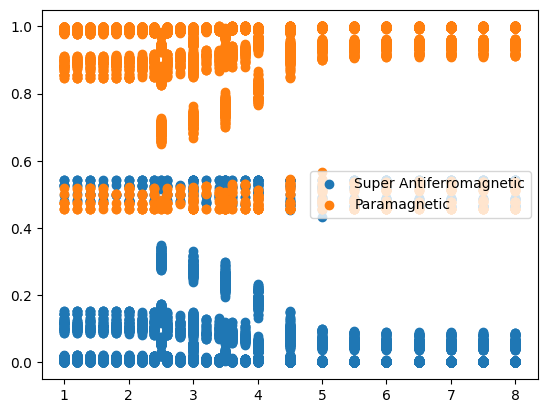

In [271]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug1234, model2)
Y_comb12 = np.append(Y1, Y2)
Y_comb1234 = np.append(Y_comb12, Y34)
Y_comb1234.shape
plt.scatter(Y_comb1234, pred_class1, label='Super Antiferromagnetic')
plt.scatter(Y_comb1234, pred_class2, label='Paramagnetic')
plt.legend()

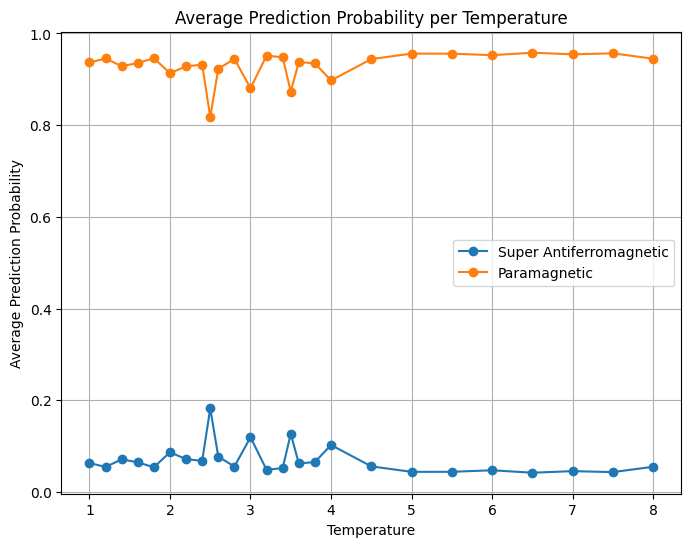

In [272]:
plot_proba(np.array(Y_comb1234), np.array(pred_class1), np.array(pred_class2), 'Super Antiferromagnetic', 'Paramagnetic')

In [273]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.4037777777777778